In [1]:
import numpy as np         # библиотека для матриц и математики
import pandas as pd        # библиотека для работы с табличками
from scipy import stats    # модуль для работы со статистикой

import matplotlib.pyplot as plt
import seaborn as sns

# стиль графиков
plt.style.use('ggplot')
# plt.style.use('fivethirtyeight')
%matplotlib inline

## О данных

https://data.mendeley.com/datasets/3t9vbwxgr5/2

Этот набор данных содержит список текстов песен с 1950 по 2019 год, описывающих музыкальные метаданные как грусть, танцевальность, громкость, акустичность и т. д. Также предоставлены тексты песен, которые можно использовать для обработки естественного языка.

Аудиоданные были очищены с помощью интегрированного движка Echo Nest® API с пакетом Spotipy Python. Spotipy API позволяет пользователю искать определенные жанры, исполнителей, песни, дату выпуска и т. д. Чтобы получить тексты песен, использованф API Lyrics Genius® в качестве базового URL-адреса для запроса данных на основе названия песни и имени исполнителя.

In [2]:
df = pd.read_csv('tcc_ceds_music.csv', index_col=False, engine='python')

print(df.shape)
df.head()

(28372, 31)


,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,pop,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110,sadness,1.0
1,4,frankie laine,i believe,1950,pop,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,...,0.001284,0.001284,0.331745,0.647540,0.954819,0.000002,0.325021,0.263240,world/life,1.0
2,6,johnnie ray,cry,1950,pop,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,...,0.002770,0.225422,0.456298,0.585288,0.840361,0.000000,0.351814,0.139112,music,1.0
3,10,pérez prado,patricia,1950,pop,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,...,0.225889,0.001548,0.686992,0.744404,0.083935,0.199393,0.775350,0.743736,romantic,1.0
4,12,giorgos papadopoulos,apopse eida oneiro,1950,pop,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,...,0.068800,0.001350,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375,romantic,1.0


В роли целевого класса выберем атрибут жанра.

In [3]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [4]:
# Подсчет количества записей для каждого уникального значения атрибута
class_counts = df['genre'].value_counts()
print(class_counts)

genre
pop        7042
country    5445
blues      4604
rock       4034
jazz       3845
reggae     2498
hip hop     904
Name: count, dtype: int64


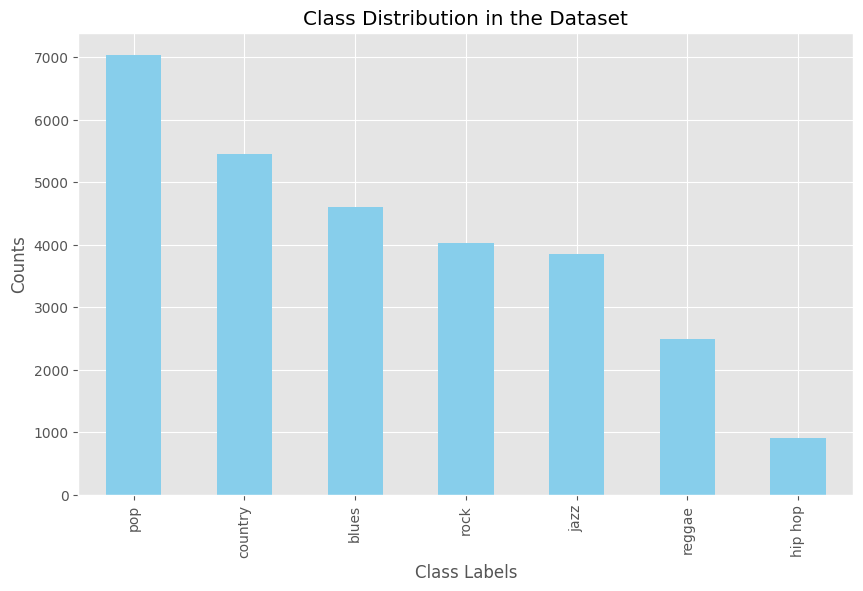

In [5]:
import matplotlib.pyplot as plt

# Построение столбчатой диаграммы для визуализации баланса классов
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Counts')
plt.title('Class Distribution in the Dataset')
plt.grid(True)
plt.show()

In [6]:
features = ['dating', 'violence', 'world/life', 'night/time',
       'shake the audience', 'family/gospel', 'romantic', 'communication',
       'obscene', 'music', 'movement/places', 'light/visual perceptions',
       'family/spiritual', 'like/girls', 'sadness', 'feelings', 'danceability',
       'loudness', 'acousticness', 'instrumentalness', 'valence', 'energy']

In [7]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

X = df[features]
y = df['genre']

# Определение моделей c учетом дисбаланса классов
knn = KNeighborsClassifier(weights='distance')
tree = DecisionTreeClassifier(class_weight='balanced')

# Определение кросс-валидации
stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Применение кросс-валидации для моделей
knn_scores = cross_val_score(knn, X, y, cv=stratified_k_fold, scoring='accuracy')
tree_scores = cross_val_score(tree, X, y, cv=stratified_k_fold, scoring='accuracy')

# Вывод результатов
print(f"Средняя точность kNN: {knn_scores.mean():.2f}")
print(f"Средняя точность дерева решений: {tree_scores.mean():.2f}")

Средняя точность kNN: 0.33
Средняя точность дерева решений: 0.30


In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_predict

# Для kNN
knn_pred = cross_val_predict(knn, X, y, cv=stratified_k_fold)
knn_precision = precision_score(y, knn_pred, average='weighted')
knn_recall = recall_score(y, knn_pred, average='weighted')
knn_f1 = f1_score(y, knn_pred, average='weighted')

# Для дерева решений
tree_pred = cross_val_predict(tree, X, y, cv=stratified_k_fold)
tree_precision = precision_score(y, tree_pred, average='weighted')
tree_recall = recall_score(y, tree_pred, average='weighted')
tree_f1 = f1_score(y, tree_pred, average='weighted')

# Вывод результатов
print("Метрики для kNN:")
print(f"Precision: {knn_precision:.2f}")
print(f"Recall: {knn_recall:.2f}")
print(f"F1-score: {knn_f1:.2f}")

print("\nМетрики для дерева решений:")
print(f"Precision: {tree_precision:.2f}")
print(f"Recall: {tree_recall:.2f}")
print(f"F1-score: {tree_f1:.2f}")

Метрики для kNN:
Precision: 0.32
Recall: 0.33
F1-score: 0.32

Метрики для дерева решений:
Precision: 0.30
Recall: 0.30
F1-score: 0.30


In [9]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Бинаризация меток классов
y_bin = label_binarize(y, classes=np.unique(y))

n_classes = y_bin.shape[1]

# Применение кросс-валидации и получение предсказаний вероятностей для каждого класса
knn_proba = cross_val_predict(knn, X, y, cv=stratified_k_fold, method='predict_proba')
tree_proba = cross_val_predict(tree, X, y, cv=stratified_k_fold, method='predict_proba')

# Вычисление ROC-кривых и AUC-ROC для каждого класса
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], knn_proba[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"ROC-AUC для класса {i}: {roc_auc:.2f} (kNN)")

    fpr, tpr, _ = roc_curve(y_bin[:, i], tree_proba[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"ROC-AUC для класса {i}: {roc_auc:.2f} (Дерево решений)")

ROC-AUC для класса 0: 0.58 (kNN)
ROC-AUC для класса 0: 0.55 (Дерево решений)
ROC-AUC для класса 1: 0.69 (kNN)
ROC-AUC для класса 1: 0.59 (Дерево решений)
ROC-AUC для класса 2: 0.78 (kNN)
ROC-AUC для класса 2: 0.65 (Дерево решений)
ROC-AUC для класса 3: 0.69 (kNN)
ROC-AUC для класса 3: 0.60 (Дерево решений)
ROC-AUC для класса 4: 0.58 (kNN)
ROC-AUC для класса 4: 0.54 (Дерево решений)
ROC-AUC для класса 5: 0.75 (kNN)
ROC-AUC для класса 5: 0.63 (Дерево решений)
ROC-AUC для класса 6: 0.67 (kNN)
ROC-AUC для класса 6: 0.57 (Дерево решений)


## Выводы

На основе полученных метрик можно сделать следующие выводы:стальных.

### Precision, Recall, F1-score:

У kNN и дерева решений примерно одинаковые значения для Precision, Recall и F1-score. Эти метрики иемонстрируют схожую способность обеих моделей к правильной классификации.
Средние значения указывают на то, что модели не ошибаются лишь в 30% процентах случаев, что может означать, что определить жанр по предоставленным характеристикам очень сложно.

### ROC-AUC:

ROC-AUC является мерой качества бинарной классификации. Когда рассматривается многоклассовая классификация, то есть ROC-AUC для каждого класса (один против всех). 
Более высокое значение ROC-AUC указывает на то, что соответствующая модель лучше разделяет этот класс от всех остальных. Более высокие значения у kNN модели.

### Выбор модели:

Если важна высокая разделимость каждого отдельного класса, то kNN в данном случае демонстрирует лучшие результаты по метрике ROC-AUC для большинства классо улучшены.


### Оптимизация моделей:
Можно попытаться оптимизировать параметры моделей, например, изменить количество соседей для kNN или настроить глубину дерева для дерева решений. 
Также можно рассмотреть использование других алгоритмов классификации или комбинацию моделей (ансамблевые методы) для улучшения общего качества классификации.


### Интерпретация результатов:
Помимо метрик, также стоит рассмотреть конкретные ошибки, которые делают модели. Это может помочь в понимании того, в каких случаях модели ошибаются и какие аспекты данных могут быть улучшены.